In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

b = [0.001, 0.01, 0.06, 1, 3, 10]

def loadData():
    train = pd.read_csv("kc_house_train_data.csv")
    test = pd.read_csv("kc_house_test_data.csv")
    return [train, test]

def normalizeData(data):
    data  = (data - data.mean())/data.std()
    return data

def load_testData():
    [train, test] = loadData()
    test_IDs = test['id']
    test_actual_price = np.array(test['price'])
    test = test.drop(['id', 'price'], axis = 1)
    i = 0
    conv_dates = []
    for value in test['date']:
        year = int(value[:4])
        month = int(value[4:6])
        day = int(value[6:8])
        conv_dates.insert(i, year*365 + month*30 + day) 
        i = i+1
    min_date = min(conv_dates)
    conv_dates = [date-min_date for date in conv_dates]
    test['date'] = conv_dates
    test = normalizeData(test)
    test_actual_price = (test_actual_price-np.mean(test_actual_price))/np.std(test_actual_price)
    return [test, test_actual_price]

def load_trainData():
    [train, test] = loadData()
    train_IDs = train['id']
    train_actual_price = np.array(train['price'])    
    train = train.drop(['id', 'price'], axis = 1)    
    i = 0
    conv_dates = []
    for value in train['date']:
        year = int(value[:4])
        month = int(value[4:6])
        day = int(value[6:8])
        conv_dates.insert(i, year*365 + month*30 + day) 
        i = i+1
    min_date = min(conv_dates)
    conv_dates = [date-min_date for date in conv_dates]
    train['date'] = conv_dates
    train = normalizeData(train)    
    train_actual_price = (train_actual_price-np.mean(train_actual_price))/np.std(train_actual_price)    
    return [train, train_actual_price]

def compute_cost(actual_price, predicted_price):
    sq_loss = (actual_price - predicted_price)**2
    cost = 0
    for i in sq_loss:
        if(np.isnan(i)):
            cost += 0
        else:
            cost += i
    return cost/(actual_price.shape[0])

def gaussian_kernel(x, mean, b):
    x_ = x-mean
    sigma = np.identity(19, dtype=int)
    sigma = (1/b)*sigma
    val = np.matmul(np.matmul(x_,sigma),x_.T)
    #val = val[0]
    return math.exp(-0.5*val)

def sum_kernel(train, x, b):
    sum = 0
    for i in range(0,train.shape[0]):
        sum += gaussian_kernel(train[i,:], x, b)
    return sum

def prediction(x, train, truth, b):
    sum = 0
    for i in range(0,train.shape[0]):
        sum += truth[i]*gaussian_kernel(train[i,:], x, b)
    return sum

def kernel_reg(train, test, train_actual_price, var):
    predictions = []
    for i in range(test.shape[0]):
        denom = sum_kernel(train, test[i], var)
        val = prediction(test[i], train, train_actual_price, var)
        val = val / denom;
        if(np.isnan(val)):
            val = 0
        predictions.append(val)
    return predictions

[train ,Y_train] = load_trainData()
[test ,Y_test] = load_testData()
X_train = np.array(train)
X_test = np.array(test)
Y_hat_test = []
for var in b:
    Y_hat_test.append(kernel_reg(X_train, X_test, Y_train, var))

C:\Users\Vivek\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


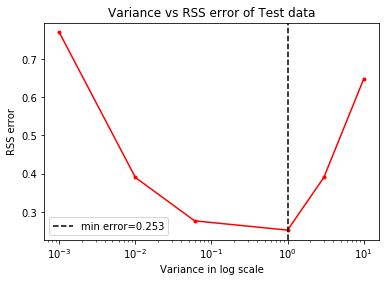

In [16]:
error = []
for i in range(len(b)):
    error.append(compute_cost(Y_test, Y_hat_test[i]))
plt.plot(b, error, '.-', c='red')
plt.xscale('log')
plt.xlabel("Variance in log scale")
plt.ylabel("RSS error")
plt.axvline(x=b[error.index(min(error))], ls='--', color='black', label="min error=%.03f"%min(error))
plt.title("Variance vs RSS error of Test data")
plt.legend()
plt.savefig("kernel1.png")
plt.show()

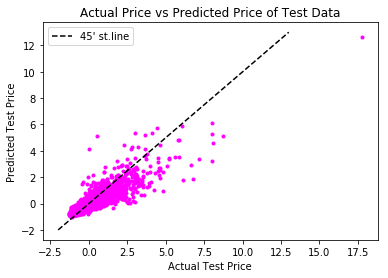

In [17]:
plt.scatter(Y_test, Y_hat_test[3], marker='.', c='magenta')
plt.plot(range(-2,14),range(-2,14),'--',c='black',label="45' st.line")
plt.xlabel("Actual Test Price")
plt.ylabel("Predicted Test Price")
plt.title("Actual Price vs Predicted Price of Test Data")
plt.legend()
plt.savefig("kernel2.png")
plt.show()

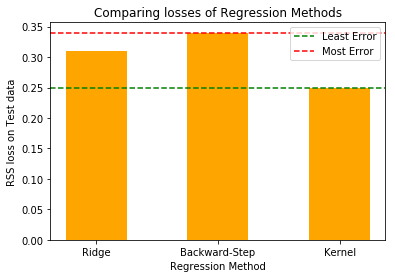

In [28]:
Y = [0.31, 0.34, 0.25]
x = range(3)
width = 0.5
plt.bar(x, Y, width, color="orange")
plt.xticks(x, ['Ridge', 'Backward-Step', 'Kernel'])
plt.xlabel("Regression Method")
plt.ylabel("RSS loss on Test data")
plt.title("Comparing losses of Regression Methods")
plt.axhline(y=Y[2], ls='--', c="Green", label='Least Error')
plt.axhline(y=Y[1], ls='--', c="Red", label='Most Error')
plt.legend()
plt.savefig("Methods compare.png")
plt.show()